### Pre-Trained models

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import cv2

from sklearn.model_selection import train_test_split

In [2]:
im_fol = os.path.join("D:/Users/James/Documents/Jupyter Saves/University/7088CEM/archive/")

In [3]:
im_fol = os.path.join("D:/Users/James/Documents/Jupyter Saves/University/7088CEM/archive/")
tum_types = ["no_tumor", "meningioma_tumor", "pituitary_tumor", "glioma_tumor"]

# Training Data
for ty in tum_types:
    ty_fol = os.path.join(im_fol, "Training", ty)
    for file in os.listdir(ty_fol):
        im_path = os.path.join(ty_fol, file)
        im = cv2.imread(im_path)

im = cv2.resize(im, (512,512))        



training = []

for ty in tum_types:
    ty_fol = os.path.join(im_fol, "Training", ty)
    tum_num = tum_types.index(ty)
    for file in os.listdir(ty_fol):
        image_arr = cv2.imread(os.path.join(ty_fol, file), cv2.IMREAD_GRAYSCALE)
        new_image_array = cv2.resize(image_arr, (128, 128))
        training.append([new_image_array , tum_num])

        
        
        
# Testing Data
testing = []

for ty in tum_types:
    ty_fol = os.path.join(im_fol, "Testing", ty)
    tum_num = tum_types.index(ty)
    for file in os.listdir(ty_fol):
        image_arr = cv2.imread(os.path.join(ty_fol, file), cv2.IMREAD_GRAYSCALE)
        new_image_array = cv2.resize(image_arr, (128, 128))
        testing.append([new_image_array , tum_num])

In [4]:
# Training
x_train = []
y_train = []

for i, j in training:
    x_train.append(i)
    y_train.append(j)
    
x_train = np.array(x_train).reshape(-1, 128, 128)
print(x_train.shape)

x_train = x_train/255
x_train = np.stack((x_train,)*3, axis=-1)



# Validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train , test_size = 0.1, random_state = 123)



# Testing
x_test = []
y_test = []

for i, j in testing:
    x_test.append(i)
    y_test.append(j)

x_test = np.array(x_test).reshape(-1, 128, 128)
print(x_test.shape)

x_test = x_test/255
x_test = np.stack((x_test,)*3, axis=-1)

(2870, 128, 128)
(394, 128, 128)


In [5]:
from keras.utils.np_utils import to_categorical   

y_train_enc = to_categorical(y_train, num_classes = 4)
y_val_enc = to_categorical(y_val, num_classes = 4)
y_test_enc = to_categorical(y_test, num_classes = 4)

In [6]:
print(x_train.shape)
print(x_val.shape)
print(y_train_enc.shape)
print(y_val_enc.shape)

(2583, 128, 128, 3)
(287, 128, 128, 3)
(2583, 4)
(287, 4)


In [7]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

import itertools

from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AveragePooling2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

In [8]:
datagen = ImageDataGenerator(
    rescale = 1./255.,
    rotation_range = 15,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True)

epochs = 30
batch_size = 32

datagen.flow(x_train, y_train_enc, batch_size = batch_size)

datagen_test = ImageDataGenerator(
    rescale = 1./255.)

In [15]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import layers


#Pre-Trained Model expects 3 channels, thus must treat greyscale as coloured image

vgg_model = VGG16(input_shape = (128, 128, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')



for layer in vgg_model.layers:
    layer.trainable = False


# Flatten the output layer to 1 dimension
x = layers.Flatten()(vgg_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer for classification
#Changed to softmax from sigmoid
x = layers.Dense(4, activation='softmax')(x)

model = tf.keras.models.Model(vgg_model.input, x)

#Changed to crossentropy from binary_crossentropy
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'categorical_crossentropy', metrics = ['acc'])

In [16]:
#vgghist = model.fit(datagen.flow(x_train, y_train_enc, batch_size = batch_size), validation_data = datagen_test.flow(x_val, y_val_enc, batch_size = batch_size), steps_per_epoch = 80, epochs = 30)

vgghist = model.fit(x_train, y_train_enc, validation_data = (x_val, y_val_enc), steps_per_epoch = 80, epochs = 50)


Epoch 1/50
80/80 [==============================] - 86s 1s/step - loss: 1.1924 - acc: 0.5184 - val_loss: 0.5719 - val_acc: 0.7944
Epoch 2/50
80/80 [==============================] - 78s 982ms/step - loss: 0.6086 - acc: 0.7671 - val_loss: 0.5295 - val_acc: 0.7666
Epoch 3/50
80/80 [==============================] - 79s 988ms/step - loss: 0.4859 - acc: 0.8089 - val_loss: 0.4149 - val_acc: 0.8432
Epoch 4/50
80/80 [==============================] - 79s 987ms/step - loss: 0.4336 - acc: 0.8317 - val_loss: 0.4109 - val_acc: 0.8153
Epoch 5/50
80/80 [==============================] - 81s 1s/step - loss: 0.3564 - acc: 0.8569 - val_loss: 0.3379 - val_acc: 0.8676
Epoch 6/50
80/80 [==============================] - 80s 1s/step - loss: 0.3418 - acc: 0.8780 - val_loss: 0.3461 - val_acc: 0.8850
Epoch 7/50
80/80 [==============================] - 80s 1s/step - loss: 0.3034 - acc: 0.8830 - val_loss: 0.3131 - val_acc: 0.8955
Epoch 8/50
80/80 [==============================] - 80s 1s/step - loss: 0.2836 - 

In [17]:
loss, accuracy = model.evaluate(x_test, y_test_enc, verbose=1)
loss_v, accuracy_v = model.evaluate(x_val, y_val_enc, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

9/9 [==============================] - 8s 836ms/step - loss: 0.2444 - acc: 0.9268
Validation: accuracy = 0.926829  ;  loss_v = 0.244379
Test: accuracy = 0.756345  ;  loss = 2.935189


In [12]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

### Evaluations

In [ ]:
score = model.evaluate(x_train, y_train_enc)
score

In [ ]:
score = model.evaluate(x_val, y_val_enc)
score

In [ ]:
score = model.evaluate(x_test, y_test_enc)
score

### Confusion Matrices

In [13]:
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 45)
#    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize = 30)
    plt.yticks(tick_marks, classes, fontsize = 30)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], fontsize = 45,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize = 45)
    plt.xlabel('Predicted label', fontsize = 45)


### Test Data Con Mat

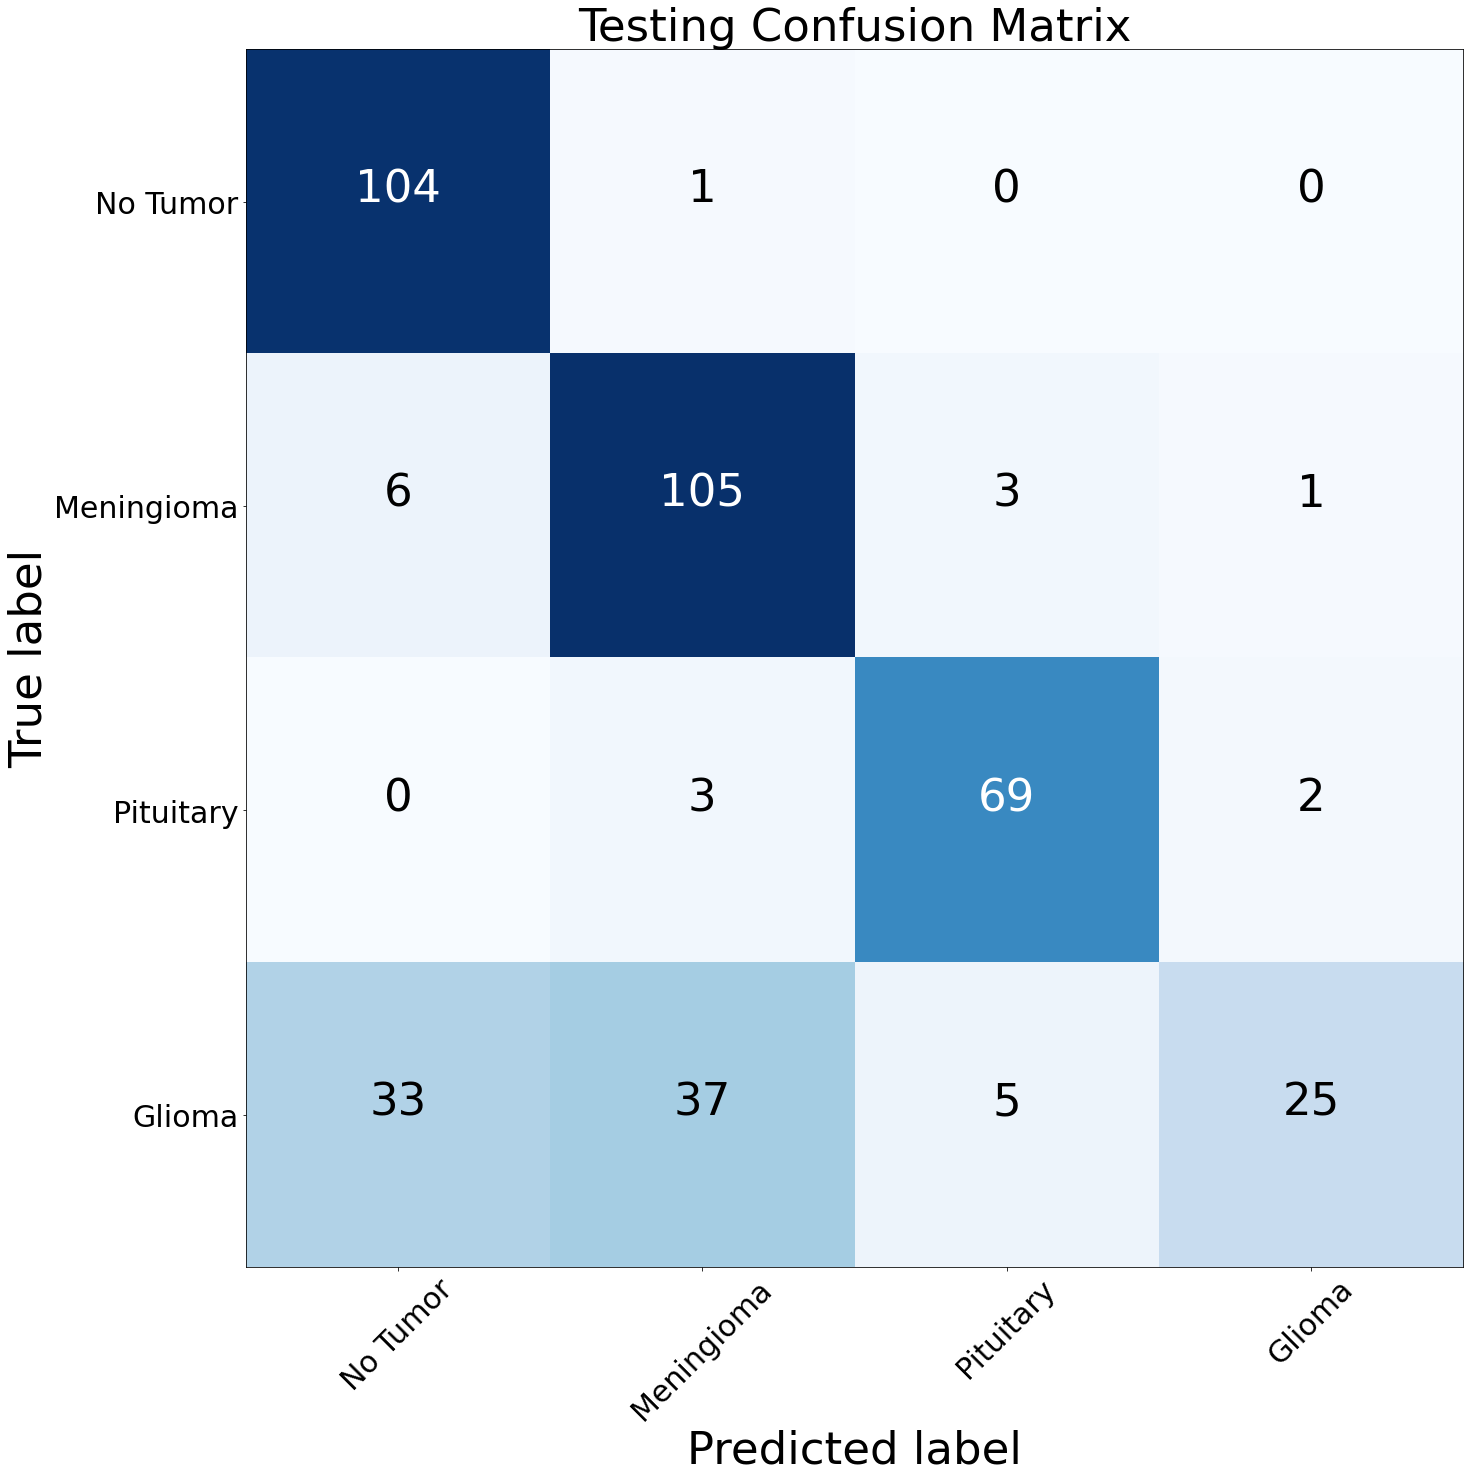

In [14]:
y_test_pred = model.predict(x_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

test_con_mat = confusion_matrix(y_test, y_test_pred_classes)


np.set_printoptions(precision=2)
plt.figure(figsize = (20,20))
plot_confusion_matrix(test_con_mat, classes = ["No Tumor", "Meningioma", "Pituitary", "Glioma"], title='Testing Confusion Matrix')